/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Calculated noise multiplier: 4.5703125


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 1/30, Loss: 1.3556, Accuracy: 14.86%, (ε = 0.17, δ = 1e-05)
Epoch 2/30, Loss: 1.3471, Accuracy: 18.82%, (ε = 0.24, δ = 1e-05)
Epoch 3/30, Loss: 1.3423, Accuracy: 20.04%, (ε = 0.30, δ = 1e-05)
Epoch 4/30, Loss: 1.3292, Accuracy: 22.82%, (ε = 0.34, δ = 1e-05)
Epoch 5/30, Loss: 1.3232, Accuracy: 27.08%, (ε = 0.38, δ = 1e-05)
Epoch 6/30, Loss: 1.3185, Accuracy: 32.49%, (ε = 0.42, δ = 1e-05)
Epoch 7/30, Loss: 1.3092, Accuracy: 33.40%, (ε = 0.46, δ = 1e-05)
Epoch 8/30, Loss: 1.3049, Accuracy: 37.18%, (ε = 0.49, δ = 1e-05)
Epoch 9/30, Loss: 1.2958, Accuracy: 43.52%, (ε = 0.52, δ = 1e-05)
Epoch 10/30, Loss: 1.2948, Accuracy: 45.00%, (ε = 0.55, δ = 1e-05)
Epoch 11/30, Loss: 1.2875, Accuracy: 51.13%, (ε = 0.58, δ = 1e-05)
Epoch 12/30, Loss: 1.2754, Accuracy: 56.10%, (ε = 0.61, δ = 1e-05)
Epoch 13/30, Loss: 1.2738, Accuracy: 58.36%, (ε = 0.63, δ = 1e-05)
Epoch 14/30, Loss: 1.2711, Accuracy: 60.13%, (ε = 0.66, δ = 1e-05)
Epoch 15/30, Loss: 1.2655, Accuracy: 62.76%, (ε = 0.68, δ = 1e-05)
Epoc

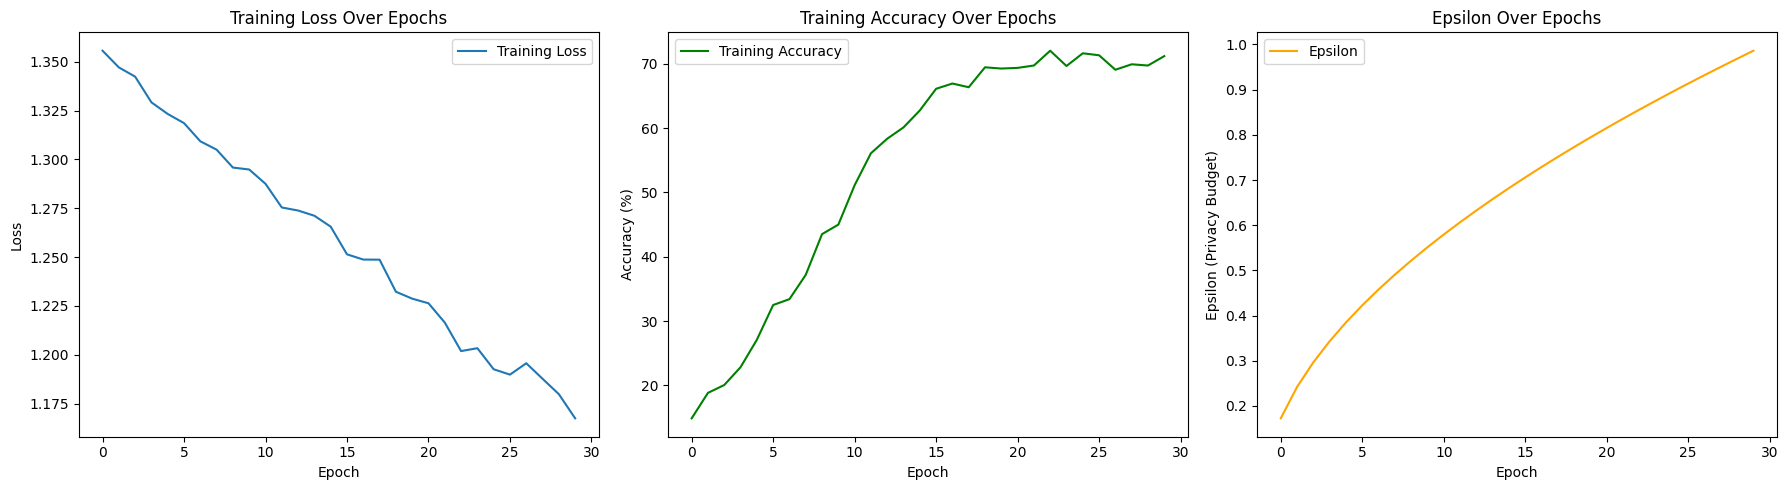

Test Loss: 1.1895
Test Accuracy: 67.92%


In [8]:
#privacy Budget 1
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from opacus import PrivacyEngine
from opacus.accountants.utils import get_noise_multiplier

# Data Preparation
# Load dataset
data_path = '/content/car.data'
columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
df = pd.read_csv(data_path, names=columns)

# Convert categorical data to numerical
df = pd.get_dummies(df, columns=["buying", "maint", "doors", "persons", "lug_boot", "safety"])

# Split features and labels
X = df.drop('class', axis=1)
y = pd.get_dummies(df['class'])

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Define a Simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training with DP-SGD and Opacus
def train_model_with_dp_sgd():
    # Hyperparameters
    batch_size = 64
    learning_rate = 1e-3
    epochs = 30
    target_epsilon = 1.0  # Privacy budget
    delta = 1e-5          # Delta value

    # Prepare DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model, loss function, and optimizer
    model = SimpleNN(input_size=X_train.shape[1], num_classes=y_train.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Compute the noise multiplier explicitly
    sample_rate = batch_size / len(X_train)
    noise_multiplier = get_noise_multiplier(
        target_epsilon=target_epsilon,
        target_delta=delta,
        sample_rate=sample_rate,
        epochs=epochs,
        accountant="prv"
    )

    print(f"Calculated noise multiplier: {noise_multiplier}")

    # Set up Opacus PrivacyEngine using make_private
    privacy_engine = PrivacyEngine()
    model, optimizer, train_loader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        noise_multiplier=noise_multiplier,
        max_grad_norm=1.0,
    )

    # Tracking loss, accuracy, and privacy metrics
    losses = []
    accuracies = []
    epsilons = []

    # Training loop
    for epoch in range(epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(target, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss /= len(train_loader)
        accuracy = 100 * correct / total
        losses.append(epoch_loss)
        accuracies.append(accuracy)

        # Track privacy loss after each epoch
        epsilon = privacy_engine.get_epsilon(delta)
        epsilons.append(epsilon)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, (ε = {epsilon:.2f}, δ = {delta})")

        # Stop training when target epsilon is reached
        if epsilon > target_epsilon:
            print("Reached target privacy budget. Stopping training.")
            break

    return model, losses, accuracies, epsilons

# Train the model and capture loss, accuracy, and epsilon
model, losses, accuracies, epsilons = train_model_with_dp_sgd()

# Plotting the Training Loss, Accuracy, and Privacy Budget (Epsilon)
plt.figure(figsize=(18, 5))

# Plot the training loss
plt.subplot(1, 3, 1)
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot the training accuracy
plt.subplot(1, 3, 2)
plt.plot(accuracies, label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.legend()

# Plot the privacy budget (epsilon)
plt.subplot(1, 3, 3)
plt.plot(epsilons, label='Epsilon', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Epsilon (Privacy Budget)')
plt.title('Epsilon Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Model Evaluation on Test Set
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    loss = nn.CrossEntropyLoss()(outputs, y_test)

    # Calculate test accuracy
    _, predicted = torch.max(outputs.data, 1)
    _, labels = torch.max(y_test, 1)
    correct = (predicted == labels).sum().item()
    accuracy = 100 * correct / labels.size(0)

    print(f"Test Loss: {loss.item():.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")


/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Calculated noise multiplier: 1.8408203125


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 1/30, Loss: 1.4006, Accuracy: 11.51%, (ε = 0.56, δ = 1e-05)
Epoch 2/30, Loss: 1.3921, Accuracy: 16.94%, (ε = 0.76, δ = 1e-05)
Epoch 3/30, Loss: 1.3884, Accuracy: 21.33%, (ε = 0.92, δ = 1e-05)
Epoch 4/30, Loss: 1.3745, Accuracy: 27.29%, (ε = 1.05, δ = 1e-05)
Epoch 5/30, Loss: 1.3663, Accuracy: 33.18%, (ε = 1.17, δ = 1e-05)
Epoch 6/30, Loss: 1.3637, Accuracy: 34.28%, (ε = 1.28, δ = 1e-05)
Epoch 7/30, Loss: 1.3520, Accuracy: 42.77%, (ε = 1.39, δ = 1e-05)
Epoch 8/30, Loss: 1.3452, Accuracy: 45.92%, (ε = 1.48, δ = 1e-05)
Epoch 9/30, Loss: 1.3386, Accuracy: 50.95%, (ε = 1.58, δ = 1e-05)
Epoch 10/30, Loss: 1.3338, Accuracy: 54.88%, (ε = 1.66, δ = 1e-05)
Epoch 11/30, Loss: 1.3237, Accuracy: 58.50%, (ε = 1.75, δ = 1e-05)
Epoch 12/30, Loss: 1.3139, Accuracy: 62.93%, (ε = 1.83, δ = 1e-05)
Epoch 13/30, Loss: 1.3117, Accuracy: 64.10%, (ε = 1.90, δ = 1e-05)
Epoch 14/30, Loss: 1.2996, Accuracy: 66.42%, (ε = 1.98, δ = 1e-05)
Epoch 15/30, Loss: 1.2925, Accuracy: 69.01%, (ε = 2.05, δ = 1e-05)
Epoc

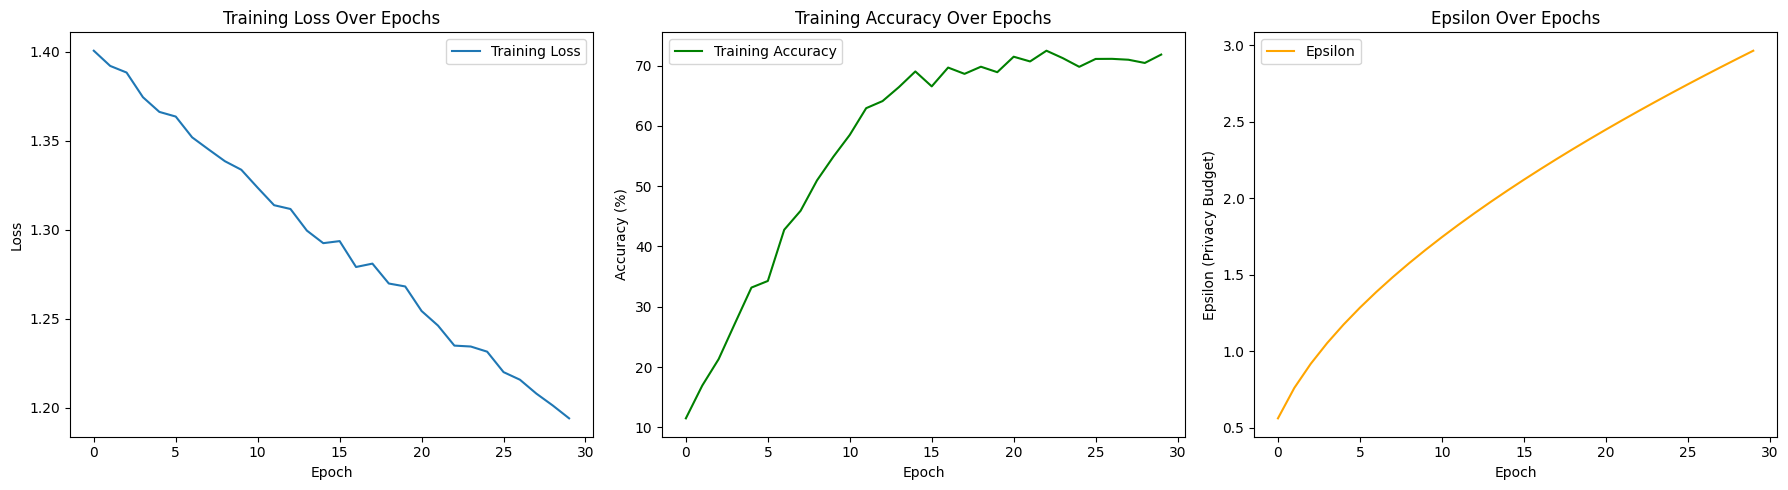

Test Loss: 1.2078
Test Accuracy: 67.92%


In [9]:
#privacy Budget 3
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from opacus import PrivacyEngine
from opacus.accountants.utils import get_noise_multiplier

# Data Preparation
# Load dataset
data_path = '/content/car.data'
columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
df = pd.read_csv(data_path, names=columns)

# Convert categorical data to numerical
df = pd.get_dummies(df, columns=["buying", "maint", "doors", "persons", "lug_boot", "safety"])

# Split features and labels
X = df.drop('class', axis=1)
y = pd.get_dummies(df['class'])

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Define a Simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training with DP-SGD and Opacus
def train_model_with_dp_sgd():
    # Hyperparameters
    batch_size = 64
    learning_rate = 1e-3
    epochs = 30
    target_epsilon = 3.0  # Privacy budget
    delta = 1e-5          # Delta value

    # Prepare DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model, loss function, and optimizer
    model = SimpleNN(input_size=X_train.shape[1], num_classes=y_train.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Compute the noise multiplier explicitly
    sample_rate = batch_size / len(X_train)
    noise_multiplier = get_noise_multiplier(
        target_epsilon=target_epsilon,
        target_delta=delta,
        sample_rate=sample_rate,
        epochs=epochs,
        accountant="prv"
    )

    print(f"Calculated noise multiplier: {noise_multiplier}")

    # Set up Opacus PrivacyEngine using make_private
    privacy_engine = PrivacyEngine()
    model, optimizer, train_loader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        noise_multiplier=noise_multiplier,
        max_grad_norm=1.0,
    )

    # Tracking loss, accuracy, and privacy metrics
    losses = []
    accuracies = []
    epsilons = []

    # Training loop
    for epoch in range(epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(target, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss /= len(train_loader)
        accuracy = 100 * correct / total
        losses.append(epoch_loss)
        accuracies.append(accuracy)

        # Track privacy loss after each epoch
        epsilon = privacy_engine.get_epsilon(delta)
        epsilons.append(epsilon)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, (ε = {epsilon:.2f}, δ = {delta})")

        # Stop training when target epsilon is reached
        if epsilon > target_epsilon:
            print("Reached target privacy budget. Stopping training.")
            break

    return model, losses, accuracies, epsilons

# Train the model and capture loss, accuracy, and epsilon
model, losses, accuracies, epsilons = train_model_with_dp_sgd()

# Plotting the Training Loss, Accuracy, and Privacy Budget (Epsilon)
plt.figure(figsize=(18, 5))

# Plot the training loss
plt.subplot(1, 3, 1)
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot the training accuracy
plt.subplot(1, 3, 2)
plt.plot(accuracies, label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.legend()

# Plot the privacy budget (epsilon)
plt.subplot(1, 3, 3)
plt.plot(epsilons, label='Epsilon', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Epsilon (Privacy Budget)')
plt.title('Epsilon Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Model Evaluation on Test Set
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    loss = nn.CrossEntropyLoss()(outputs, y_test)

    # Calculate test accuracy
    _, predicted = torch.max(outputs.data, 1)
    _, labels = torch.max(y_test, 1)
    correct = (predicted == labels).sum().item()
    accuracy = 100 * correct / labels.size(0)

    print(f"Test Loss: {loss.item():.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")


/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Calculated noise multiplier: 1.16455078125


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 1/30, Loss: 1.4333, Accuracy: 17.08%, (ε = 1.33, δ = 1e-05)
Epoch 2/30, Loss: 1.4212, Accuracy: 18.56%, (ε = 1.69, δ = 1e-05)
Epoch 3/30, Loss: 1.4133, Accuracy: 19.69%, (ε = 1.98, δ = 1e-05)
Epoch 4/30, Loss: 1.4045, Accuracy: 20.21%, (ε = 2.23, δ = 1e-05)
Epoch 5/30, Loss: 1.4025, Accuracy: 19.19%, (ε = 2.45, δ = 1e-05)
Epoch 6/30, Loss: 1.3904, Accuracy: 25.90%, (ε = 2.66, δ = 1e-05)
Epoch 7/30, Loss: 1.3830, Accuracy: 26.84%, (ε = 2.86, δ = 1e-05)
Epoch 8/30, Loss: 1.3743, Accuracy: 28.10%, (ε = 3.04, δ = 1e-05)
Epoch 9/30, Loss: 1.3681, Accuracy: 31.54%, (ε = 3.21, δ = 1e-05)
Epoch 10/30, Loss: 1.3602, Accuracy: 35.11%, (ε = 3.38, δ = 1e-05)
Epoch 11/30, Loss: 1.3544, Accuracy: 37.41%, (ε = 3.54, δ = 1e-05)
Epoch 12/30, Loss: 1.3423, Accuracy: 45.79%, (ε = 3.70, δ = 1e-05)
Epoch 13/30, Loss: 1.3316, Accuracy: 49.49%, (ε = 3.85, δ = 1e-05)
Epoch 14/30, Loss: 1.3313, Accuracy: 46.26%, (ε = 3.99, δ = 1e-05)
Epoch 15/30, Loss: 1.3234, Accuracy: 51.70%, (ε = 4.13, δ = 1e-05)
Epoc

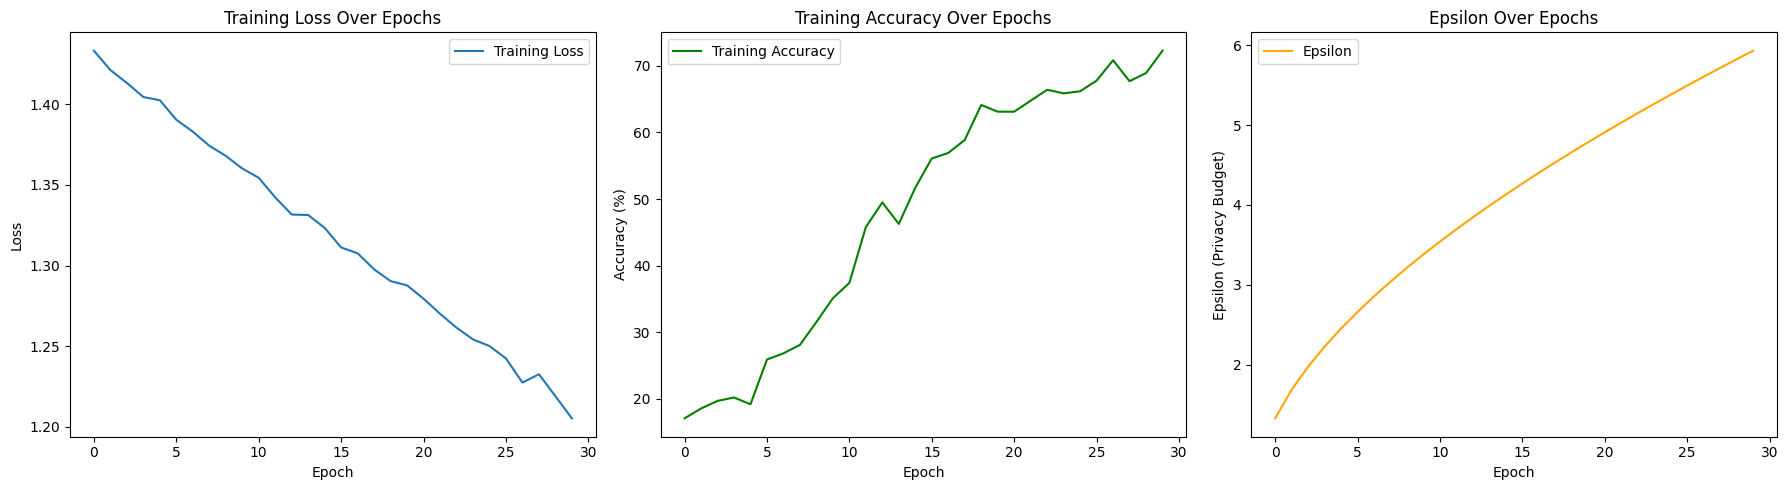

Test Loss: 1.2135
Test Accuracy: 67.05%


In [10]:
#privacy Budget 6
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from opacus import PrivacyEngine
from opacus.accountants.utils import get_noise_multiplier

# Data Preparation
# Load dataset
data_path = '/content/car.data'
columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
df = pd.read_csv(data_path, names=columns)

# Convert categorical data to numerical
df = pd.get_dummies(df, columns=["buying", "maint", "doors", "persons", "lug_boot", "safety"])

# Split features and labels
X = df.drop('class', axis=1)
y = pd.get_dummies(df['class'])

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Define a Simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training with DP-SGD and Opacus
def train_model_with_dp_sgd():
    # Hyperparameters
    batch_size = 64
    learning_rate = 1e-3
    epochs = 30
    target_epsilon = 6.0  # Privacy budget
    delta = 1e-5          # Delta value

    # Prepare DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model, loss function, and optimizer
    model = SimpleNN(input_size=X_train.shape[1], num_classes=y_train.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Compute the noise multiplier explicitly
    sample_rate = batch_size / len(X_train)
    noise_multiplier = get_noise_multiplier(
        target_epsilon=target_epsilon,
        target_delta=delta,
        sample_rate=sample_rate,
        epochs=epochs,
        accountant="prv"
    )

    print(f"Calculated noise multiplier: {noise_multiplier}")

    # Set up Opacus PrivacyEngine using make_private
    privacy_engine = PrivacyEngine()
    model, optimizer, train_loader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        noise_multiplier=noise_multiplier,
        max_grad_norm=1.0,
    )

    # Tracking loss, accuracy, and privacy metrics
    losses = []
    accuracies = []
    epsilons = []

    # Training loop
    for epoch in range(epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(target, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss /= len(train_loader)
        accuracy = 100 * correct / total
        losses.append(epoch_loss)
        accuracies.append(accuracy)

        # Track privacy loss after each epoch
        epsilon = privacy_engine.get_epsilon(delta)
        epsilons.append(epsilon)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, (ε = {epsilon:.2f}, δ = {delta})")

        # Stop training when target epsilon is reached
        if epsilon > target_epsilon:
            print("Reached target privacy budget. Stopping training.")
            break

    return model, losses, accuracies, epsilons

# Train the model and capture loss, accuracy, and epsilon
model, losses, accuracies, epsilons = train_model_with_dp_sgd()

# Plotting the Training Loss, Accuracy, and Privacy Budget (Epsilon)
plt.figure(figsize=(18, 5))

# Plot the training loss
plt.subplot(1, 3, 1)
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot the training accuracy
plt.subplot(1, 3, 2)
plt.plot(accuracies, label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.legend()

# Plot the privacy budget (epsilon)
plt.subplot(1, 3, 3)
plt.plot(epsilons, label='Epsilon', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Epsilon (Privacy Budget)')
plt.title('Epsilon Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Model Evaluation on Test Set
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    loss = nn.CrossEntropyLoss()(outputs, y_test)

    # Calculate test accuracy
    _, predicted = torch.max(outputs.data, 1)
    _, labels = torch.max(y_test, 1)
    correct = (predicted == labels).sum().item()
    accuracy = 100 * correct / labels.size(0)

    print(f"Test Loss: {loss.item():.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")
